# SAM8905 Reverb FX - ALG 1 Analysis (Diffusion)

This notebook analyzes ALG 1 of the Keyfox10 reverb effect.

**ALG 1 Purpose:** Diffusion/scatter processing - spreads early reflections for a more natural reverb sound.

**Key characteristics:**
- Located at A-RAM 0x40-0x7F (22kHz ALG 1)
- Used by Slot 5 (D-RAM ALG=2)
- Heavy DAC output: 13 WACC instructions
- No WXY+WSP combo (uses MIX values from previous slot)
- Reads from D-RAM and SRAM for extensive multiply-accumulate operations

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import sam8905_interpreter
reload(sam8905_interpreter)

from sam8905_interpreter import (
    SAM8905Interpreter,
    plot_waveform,
    export_wav,
    print_state,
    print_dram_changes
)
from sam8905_aram_decoder import decode_algorithm

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 4)

## ALG 1 from Keyfox10 FX Chip

A-RAM addresses 0x40-0x7F (64 instructions for 22kHz ALG 1)

In [2]:
# A-RAM 0x40-0x7F: 22kHz ALG 1 (D-RAM ALG=2, Used by Slot 5 - Diffusion)
# From WIP_fx_reverb_analysis.md
aram_alg1 = [
    0x30EF,  # PC00: RM 6, <WPHI>                      - PHI = D[6]
    0x48FD,  # PC01: RM 9, <WWF>                       - WWF = D[9] (waveform config)
    0x6ADF,  # PC02: RADD 13, <WM>                     - D[13] = A+B
    0x703F,  # PC03: RM 14, <WA, WB>                   - A=B=D[14]
    0x0000,  # PC04: RM 0, <WA,WB,WM,WPHI,WXY,clrB,WWF,WACC>  - WACC #1
    0x6BDF,  # PC05: RADD 13, <WM> [WSP]               - D[13] = A+B, WSP active
    0x38EF,  # PC06: RM 7, <WPHI>                      - PHI = D[7]
    0x50FC,  # PC07: RM 10, <WWF,WACC>                 - WWF=D[10], WACC #2
    0x687F,  # PC08: RM 13, <WA>                       - A = D[13]
    0x7CBE,  # PC09: RP 15, <WB,WACC>                  - B = product, WACC #3
    0x18F7,  # PC10: RM 3, <WXY>                       - WXY - waveform read
    0x7A7F,  # PC11: RADD 15, <WA>                     - A = A+B
    0x40EF,  # PC12: RM 8, <WPHI>                      - PHI = D[8]
    0x58FC,  # PC13: RM 11, <WWF,WACC>                 - WWF=D[11], WACC #4
    0x7CBE,  # PC14: RP 15, <WB,WACC>                  - B = product, WACC #5
    0x6ADF,  # PC15: RADD 13, <WM>                     - D[13] = A+B
    0x18F7,  # PC16: RM 3, <WXY>                       - WXY - waveform read
    0x00BF,  # PC17: RM 0, <WB>                        - B = D[0]
    0x307F,  # PC18: RM 6, <WA>                        - A = D[6]
    0x32CE,  # PC19: RADD 6, <WM,WPHI,WACC>            - D[6]=A+B, PHI=bus, WACC #6
    0x48FC,  # PC20: RM 9, <WWF,WACC>                  - WWF=D[9], WACC #7
    0x387F,  # PC21: RM 7, <WA>                        - A = D[7]
    0x3ADF,  # PC22: RADD 7, <WM>                      - D[7] = A+B
    0x407F,  # PC23: RM 8, <WA>                        - A = D[8]
    0x42DF,  # PC24: RADD 8, <WM>                      - D[8] = A+B
    0x7CBF,  # PC25: RP 15, <WB>                       - B = product
    0x20F7,  # PC26: RM 4, <WXY>                       - WXY - waveform read
    0x687F,  # PC27: RM 13, <WA>                       - A = D[13]
    0x38EF,  # PC28: RM 7, <WPHI>                      - PHI = D[7]
    0x50FD,  # PC29: RM 10, <WWF>                      - WWF = D[10]
    0x7A7E,  # PC30: RADD 15, <WA,WACC>                - A=A+B, WACC #8
    0x7CBE,  # PC31: RP 15, <WB,WACC>                  - B = product, WACC #9
    0x28F7,  # PC32: RM 5, <WXY>                       - WXY - waveform read
    0x7A7F,  # PC33: RADD 15, <WA>                     - A = A+B
    0x40EF,  # PC34: RM 8, <WPHI>                      - PHI = D[8]
    0x58FD,  # PC35: RM 11, <WWF>                      - WWF = D[11]
    0x7CBE,  # PC36: RP 15, <WB,WACC>                  - B = product, WACC #10
    0x6ADE,  # PC37: RADD 13, <WM,WACC>                - D[13]=A+B, WACC #11
    0x28F7,  # PC38: RM 5, <WXY>                       - WXY - waveform read
    0x08BF,  # PC39: RM 1, <WB>                        - B = D[1]
    0x307F,  # PC40: RM 6, <WA>                        - A = D[6]
    0x32DF,  # PC41: RADD 6, <WM>                      - D[6] = A+B
    0x493F,  # PC42: RM 9, <WA,WB> [WSP]               - A=B=D[9], WSP active
    0x4ADF,  # PC43: RADD 9, <WM>                      - D[9] = A+B
    0x60BF,  # PC44: RM 12, <WB>                       - B = D[12]
    0x4BDF,  # PC45: RADD 9, <WM> [WSP]                - D[9]=A+B, WSP active
    0x08BF,  # PC46: RM 1, <WB>                        - B = D[1]
    0x387F,  # PC47: RM 7, <WA>                        - A = D[7]
    0x3ADF,  # PC48: RADD 7, <WM>                      - D[7] = A+B
    0x513F,  # PC49: RM 10, <WA,WB> [WSP]              - A=B=D[10], WSP active
    0x52DF,  # PC50: RADD 10, <WM>                     - D[10] = A+B
    0x60BF,  # PC51: RM 12, <WB>                       - B = D[12]
    0x53DF,  # PC52: RADD 10, <WM> [WSP]               - D[10]=A+B, WSP active
    0x08BF,  # PC53: RM 1, <WB>                        - B = D[1]
    0x407F,  # PC54: RM 8, <WA>                        - A = D[8]
    0x42DF,  # PC55: RADD 8, <WM>                      - D[8] = A+B
    0x593F,  # PC56: RM 11, <WA,WB> [WSP]              - A=B=D[11], WSP active
    0x5ADF,  # PC57: RADD 11, <WM>                     - D[11] = A+B
    0x60BF,  # PC58: RM 12, <WB>                       - B = D[12]
    0x5BDF,  # PC59: RADD 11, <WM> [WSP]               - D[11]=A+B, WSP active
    0x7CBE,  # PC60: RP 15, <WB,WACC>                  - B = product, WACC #12
    0x687E,  # PC61: RM 13, <WA,WACC>                  - A = D[13], WACC #13
]

# Pad to 64 instructions (PC62-63 are reserved NOPs)
aram_alg1 += [0x7FFF] * (64 - len(aram_alg1))

print(f"ALG 1: {len(aram_alg1)} instructions")
print()
print(decode_algorithm(aram_alg1, 1))

ALG 1: 64 instructions

=== Algorithm 1 ===

PC00: 30EF  RM 6, <WPHI>
PC01: 48FD  RM 9, <WWF>
PC02: 6ADF  RADD 13, <WM>
PC03: 703F  RM 14, <WA, WB>
PC04: 0000  RM 0, <WA, WB, WM, WPHI, WXY, clearB, WWF, WACC>
PC05: 6BDF  RADD 13, <WM, WSP> ***
PC06: 38EF  RM 7, <WPHI>
PC07: 50FC  RM 10, <WWF, WACC>
PC08: 687F  RM 13, <WA>
PC09: 7CBE  RP, <WB, WACC>
PC10: 18F7  RM 3, <WXY>
PC11: 7A7F  RADD, <WA>
PC12: 40EF  RM 8, <WPHI>
PC13: 58FC  RM 11, <WWF, WACC>
PC14: 7CBE  RP, <WB, WACC>
PC15: 6ADF  RADD 13, <WM>
PC16: 18F7  RM 3, <WXY>
PC17: 00BF  RM 0, <WB>
PC18: 307F  RM 6, <WA>
PC19: 32CE  RADD 6, <WM, WPHI, WACC>
PC20: 48FC  RM 9, <WWF, WACC>
PC21: 387F  RM 7, <WA>
PC22: 3ADF  RADD 7, <WM>
PC23: 407F  RM 8, <WA>
PC24: 42DF  RADD 8, <WM>
PC25: 7CBF  RP, <WB>
PC26: 20F7  RM 4, <WXY>
PC27: 687F  RM 13, <WA>
PC28: 38EF  RM 7, <WPHI>
PC29: 50FD  RM 10, <WWF>
PC30: 7A7E  RADD, <WA, WACC>
PC31: 7CBE  RP, <WB, WACC>
PC32: 28F7  RM 5, <WXY>
PC33: 7A7F  RADD, <WA>
PC34: 40EF  RM 8, <WPHI>
PC35: 58FD  R

## D-RAM Configuration (Slot 5 - Diffusion)

In [3]:
# D-RAM for Slot 5 (ALG 1 / Diffusion)
# From WIP_fx_reverb_analysis.md
dram_slot5 = [
    0x00080,  # word 0: PHI offset / constant
    0x00180,  # word 1: Modulation offset
    0x1003F,  # word 2: WWF config (external waveform)
    0x10000,  # word 3: Amplitude coefficient
    0x00100,  # word 4: Delay line address
    0x00100,  # word 5: Delay line address 2
    0x3FF00,  # word 6: Large delay address
    0x6DF00,  # word 7: Delay address (phase modulation)
    0x5A100,  # word 8: Delay address (phase modulation)
    0x40402,  # word 9: WWF/SRAM bank config
    0x40402,  # word 10: WWF/SRAM bank config
    0x40402,  # word 11: WWF/SRAM bank config
    0x40402,  # word 12: Modulation depth
    0x00000,  # word 13: Working accumulator
    0x40000,  # word 14: Feedback state
    0x3C280,  # word 15: 0011 1100 0010 1000 0000 → IDLE=0, ALG=2 (22kHz ALG 1)
]

print("D-RAM Slot 5 configuration:")
for i, val in enumerate(dram_slot5):
    signed_val = val if val < 0x40000 else val - 0x80000
    print(f"  D[{i:2d}] = 0x{val:05X} (signed: {signed_val:+8d})")

D-RAM Slot 5 configuration:
  D[ 0] = 0x00080 (signed:     +128)
  D[ 1] = 0x00180 (signed:     +384)
  D[ 2] = 0x1003F (signed:   +65599)
  D[ 3] = 0x10000 (signed:   +65536)
  D[ 4] = 0x00100 (signed:     +256)
  D[ 5] = 0x00100 (signed:     +256)
  D[ 6] = 0x3FF00 (signed:  +261888)
  D[ 7] = 0x6DF00 (signed:   -73984)
  D[ 8] = 0x5A100 (signed:  -155392)
  D[ 9] = 0x40402 (signed:  -261118)
  D[10] = 0x40402 (signed:  -261118)
  D[11] = 0x40402 (signed:  -261118)
  D[12] = 0x40402 (signed:  -261118)
  D[13] = 0x00000 (signed:       +0)
  D[14] = 0x40000 (signed:  -262144)
  D[15] = 0x3C280 (signed:  +246400)


## SRAM Buffer Setup

ALG 1 reads from external SRAM (via WXY waveform reads). In the real reverb chain, ALG 0 writes audio samples to SRAM, and ALG 1 reads them for processing.

For this analysis, we'll initialize the SRAM with a test pattern that simulates the output of ALG 0.

In [9]:
# Initialize SRAM buffer with a test pattern (sine wave)
# ALG 1 reads from SRAM addresses determined by PHI and WF settings
# Based on the first run, addresses are in the 0x2000-0x3000 range

# Create a 64KB SRAM buffer (full address space)
SRAM_SIZE = 65536
sram_buffer = np.zeros(SRAM_SIZE, dtype=np.int16)

# Fill SRAM with a sine pattern across the address range ALG 1 uses
# Based on trace: addresses 0x2001-0x2FB1
np.random.seed(42)
for addr in range(0x1000, 0x4000):  # Wider range to cover all addresses
    phase = addr * 2 * np.pi / 500
    amplitude = 500  # Reasonable amplitude for 12-bit signed values
    sram_buffer[addr] = int(amplitude * np.sin(phase))

# Log SRAM reads during execution
sram_read_log = []
frame_counter = 0

def waveform_read_callback(address):
    """Called when SAM reads external waveform (SRAM)"""
    global frame_counter
    # address is 17-bit: (WF[6:0] << 10) | (PHI[11:2])
    value = int(sram_buffer[address % SRAM_SIZE])
    sram_read_log.append((frame_counter, address, value))
    return value

print(f"SRAM buffer initialized: {SRAM_SIZE} locations")
print(f"Sample values at key addresses:")
for addr in [0x2001, 0x2200, 0x2500, 0x2800]:
    print(f"  SRAM[0x{addr:04X}] = {sram_buffer[addr]}")

SRAM buffer initialized: 65536 locations
Sample values at key addresses:
  SRAM[0x2001] = 328
  SRAM[0x2200] = 273
  SRAM[0x2500] = -172
  SRAM[0x2800] = 62


## Run ALG 1 (Diffusion)

Execute the algorithm and collect output samples.

In [10]:
# Create interpreter and configure
sam = SAM8905Interpreter()

# Load ALG 1 at offset 64 (0x40 for 22kHz ALG 1)
sam.load_aram(aram_alg1, offset=64)

# Load D-RAM for slot 5
sam.load_dram(5, dram_slot5)

# Set up SRAM read callback
sam.waveform_read = waveform_read_callback

print("Interpreter configured:")
print(f"  A-RAM loaded at offset 64 (ALG 1)")
print(f"  D-RAM slot 5 loaded")
print(f"  Waveform read callback active")

Interpreter configured:
  A-RAM loaded at offset 64 (ALG 1)
  D-RAM slot 5 loaded
  Waveform read callback active


In [13]:
# Reset and run
sam.reset()
sam.load_aram(aram_alg1, offset=64)
sam.load_dram(5, dram_slot5)
sam.waveform_read = waveform_read_callback

# ALG 1 has no WXY+WSP instruction to set MIX values
# In the real reverb chain, MIX would be set by slot 4 (ALG 0)
# For testing, manually set MIX to enable output
sam.state.mix_l = 7  # 0dB (full volume)
sam.state.mix_r = 7  # 0dB

# Clear logs
sram_read_log.clear()
frame_counter = 0

# Generate samples - one frame at a time to track frame counter
NUM_FRAMES = 500
samples_list = []

for i in range(NUM_FRAMES):
    frame_counter = i  # Update global counter before each frame
    frame_samples = sam.run(1, active_slots=[5])
    samples_list.append(frame_samples[0])

samples = np.array(samples_list)

print(f"Generated {len(samples)} samples")
print(f"L range: [{samples[:, 0].min()}, {samples[:, 0].max()}]")
print(f"R range: [{samples[:, 1].min()}, {samples[:, 1].max()}]")
print(f"SRAM reads: {len(sram_read_log)}")

Generated 500 samples
L range: [-32768, 32767]
R range: [-32768, 32767]
SRAM reads: 2000


## Output Visualization

ALG 1 has 13 WACC instructions - the most of any reverb algorithm. This produces dense output for the diffusion effect.

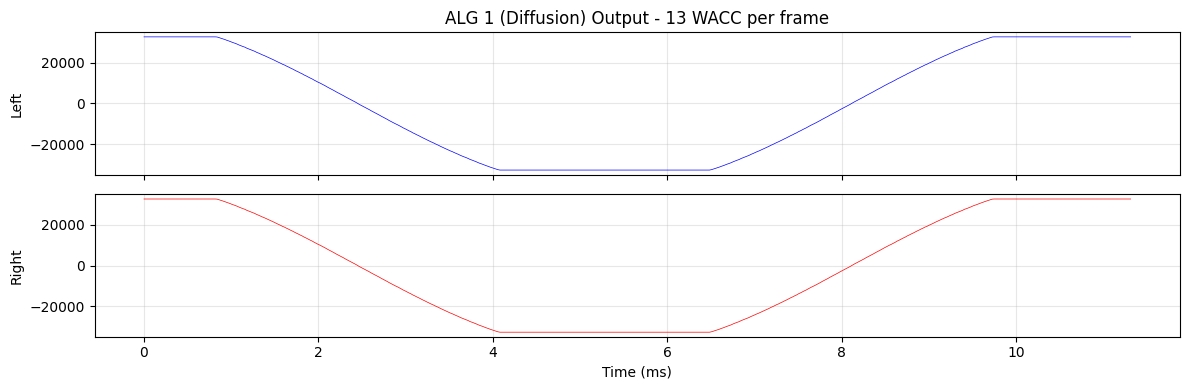


Signal Statistics:
  L channel: mean=35.82, std=26280.20
  R channel: mean=35.82, std=26280.20


In [14]:
# Plot output waveform
plot_waveform(samples, title="ALG 1 (Diffusion) Output - 13 WACC per frame")
plt.show()

# Show signal statistics
print("\nSignal Statistics:")
print(f"  L channel: mean={samples[:, 0].mean():.2f}, std={samples[:, 0].std():.2f}")
print(f"  R channel: mean={samples[:, 1].mean():.2f}, std={samples[:, 1].std():.2f}")

## SRAM Read Analysis

Examine which SRAM addresses are read by ALG 1 and how they affect the output.

In [15]:
if sram_read_log:
    print(f"SRAM Read Summary ({len(sram_read_log)} reads total):")
    
    # Count reads per address
    addr_counts = {}
    for frame, addr, val in sram_read_log:
        addr_counts[addr] = addr_counts.get(addr, 0) + 1
    
    # Show unique addresses
    unique_addrs = sorted(addr_counts.keys())
    print(f"\nUnique addresses read: {len(unique_addrs)}")
    
    # Show first few frames in detail
    print("\nFirst 3 frames:")
    for frame in range(min(3, NUM_FRAMES)):
        frame_reads = [(addr, val) for f, addr, val in sram_read_log if f == frame]
        print(f"  Frame {frame}: {len(frame_reads)} reads")
        for addr, val in frame_reads[:5]:  # Show first 5
            print(f"    SRAM[0x{addr:04X}] = {val}")
        if len(frame_reads) > 5:
            print(f"    ... and {len(frame_reads) - 5} more")
    
    # Analyze address patterns
    if len(unique_addrs) > 1:
        addr_array = np.array(unique_addrs)
        print(f"\nAddress range: 0x{addr_array.min():04X} - 0x{addr_array.max():04X}")
else:
    print("No SRAM reads recorded")

SRAM Read Summary (2000 reads total):

Unique addresses read: 1501

First 3 frames:
  Frame 0: 4 reads
    SRAM[0x2001] = 328
    SRAM[0x2DBE] = 240
    SRAM[0x2B42] = 400
    SRAM[0x27FF] = 68
  Frame 1: 4 reads
    SRAM[0x2001] = 328
    SRAM[0x2DBF] = 235
    SRAM[0x2B43] = 404
    SRAM[0x2800] = 62
  Frame 2: 4 reads
    SRAM[0x2001] = 328
    SRAM[0x2DC0] = 229
    SRAM[0x2B44] = 408
    SRAM[0x2801] = 56

Address range: 0x2001 - 0x2FB1


## Final State Inspection

In [16]:
print_state(sam.state, slot=5)

SAM8905 Register State
  A = 0x01F55  (+8021)
  B = 0x03180  (+12672)
  X = 0x04B  (+75)
  Y = 0x002  (+2)
  PHI = 0xFB2  (4018)
  WF = 0x002
  MUL = 0x00009  (+9)

  CARRY = False
  CLEAR_RQST = True
  INT_MOD = False

  MIX_L = 7  MIX_R = 7
  L_ACC = +41151  R_ACC = +41151

D-RAM Slot 5:
  D[ 0] = 0x00080  (+128)
  D[ 1] = 0x00180  (+384)
  D[ 2] = 0x1003F  (+65599)
  D[ 3] = 0x10000  (+65536)
  D[ 4] = 0x00100  (+256)
  D[ 5] = 0x00100  (+256)
  D[ 6] = 0x4F900  (-198400)
  D[ 7] = 0x7D900  (-9984)
  D[ 8] = 0x69B00  (-91392)
  D[ 9] = 0x40402  (-261118)
  D[10] = 0x40402  (-261118)
  D[11] = 0x40402  (-261118)
  D[12] = 0x40402  (-261118)
  D[13] = 0x01F55  (+8021)
  D[14] = 0x40000  (-262144)
  D[15] = 0x3C280  (+246400)
